# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [9]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)

# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

(10000, 32, 32, 3)
(10000, 3072) [0.42352941 0.4745098  0.54901961 ... 0.56470588 0.61960784 0.67058824]
(10000, 3073)


# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [295]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [296]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))
print(probs)
# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
print(probs)
assert np.isclose(probs[0], 1.0)
# Make sure it works on batches
probs = linear_classifer.softmax(np.array([[1000, 0, 0], [2000, 0, 3000]]))
print(probs)

[2.06106005e-09 4.53978686e-05 9.99954600e-01]
[1. 0. 0.]
[[1. 0. 0.]
 [0. 0. 1.]]


Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [297]:
probs = linear_classifer.softmax(np.array([1, 0, 0]))
print(linear_classifer.cross_entropy_loss(probs, np.array([1])))

probs = linear_classifer.softmax(np.array([[-5, 0, 5], [-5, 10, 0]]))
print(linear_classifer.cross_entropy_loss(probs, np.array([1, 2])))

1.551444713932051
7.5034030741673625


После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [298]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), np.array([1]))
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, np.array([1])), np.array([1, 0, 0], np.float))

loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([[1, 0, 0],[5,0,-5]]), np.array([1, 2]))
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, np.array([1, 2])), np.array([[1, 0, 0],[5,0,-5]], np.float))

Gradient check passed!
Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [301]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [343]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)
#print(W, W.shape,"\n---\n", X, X.shape, "\n---\n", target_index.shape, "\n---\n",)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [344]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
loss, grad = linear_classifer.l2_regularization(W, 0.01)
print(W,loss, grad)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

[[ 1.  2.]
 [-1.  1.]
 [ 1.  2.]] 0.12 [[ 0.02  0.04]
 [-0.02  0.02]
 [ 0.02  0.04]]
Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [353]:
# TODO: Implement LinearSoftmaxClassifier.fit function
print("train_X.shape\n", train_X.shape)
print("train_y.shape\n", train_y.shape)
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)


train_X.shape
 (10000, 3073)
train_y.shape
 (10000,)
Epoch 0, loss: 2.473370
Epoch 1, loss: 2.345278
Epoch 2, loss: 2.312869
Epoch 3, loss: 2.304659
Epoch 4, loss: 2.302558
Epoch 5, loss: 2.302069
Epoch 6, loss: 2.301932
Epoch 7, loss: 2.301888
Epoch 8, loss: 2.301901
Epoch 9, loss: 2.301855


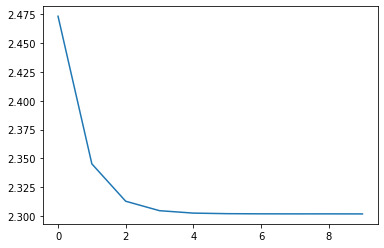

In [354]:
# let's look at the loss history!
plt.plot(loss_history)

In [361]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.147
Epoch 0, loss: 2.301849
Epoch 1, loss: 2.301851
Epoch 2, loss: 2.301883
Epoch 3, loss: 2.301866
Epoch 4, loss: 2.301910
Epoch 5, loss: 2.301893
Epoch 6, loss: 2.301831
Epoch 7, loss: 2.301876
Epoch 8, loss: 2.301875
Epoch 9, loss: 2.301871
Epoch 10, loss: 2.301865
Epoch 11, loss: 2.301897
Epoch 12, loss: 2.301906
Epoch 13, loss: 2.301902
Epoch 14, loss: 2.301884
Epoch 15, loss: 2.301851
Epoch 16, loss: 2.301875
Epoch 17, loss: 2.301863
Epoch 18, loss: 2.301906
Epoch 19, loss: 2.301880
Epoch 20, loss: 2.301876
Epoch 21, loss: 2.301888
Epoch 22, loss: 2.301884
Epoch 23, loss: 2.301848
Epoch 24, loss: 2.301865
Epoch 25, loss: 2.301877
Epoch 26, loss: 2.301883
Epoch 27, loss: 2.301842
Epoch 28, loss: 2.301857
Epoch 29, loss: 2.301892
Epoch 30, loss: 2.301902
Epoch 31, loss: 2.301878
Epoch 32, loss: 2.301911
Epoch 33, loss: 2.301840
Epoch 34, loss: 2.301879
Epoch 35, loss: 2.301881
Epoch 36, loss: 2.301867
Epoch 37, loss: 2.301880
Epoch 38, loss: 2.301858
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [363]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

classifiers = []
accuracies = []

best_classifier = None
best_val_accuracy = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

In [ ]:
for lr in learning_rates:
    for reg in reg_strengths:
        print("\n### lr=%f reg=%f" % (lr, reg))
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=batch_size, reg=reg)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        classifiers.append(classifier)
        accuracies.append(accuracy)

### lr=0.001000 reg=0.000100
Epoch 0, loss: 2.301947
Epoch 1, loss: 2.300756
Epoch 2, loss: 2.299599
Epoch 3, loss: 2.298595
Epoch 4, loss: 2.297555
Epoch 5, loss: 2.296602
Epoch 6, loss: 2.295550
Epoch 7, loss: 2.294608
Epoch 8, loss: 2.293629
Epoch 9, loss: 2.292787
Epoch 10, loss: 2.291914
Epoch 11, loss: 2.291003
Epoch 12, loss: 2.289983
Epoch 13, loss: 2.289078
Epoch 14, loss: 2.288257
Epoch 15, loss: 2.287151
Epoch 16, loss: 2.286213
Epoch 17, loss: 2.285540
Epoch 18, loss: 2.284632
Epoch 19, loss: 2.283490
Epoch 20, loss: 2.282859
Epoch 21, loss: 2.281942
Epoch 22, loss: 2.281267
Epoch 23, loss: 2.280555
Epoch 24, loss: 2.279693
Epoch 25, loss: 2.278828
Epoch 26, loss: 2.277902
Epoch 27, loss: 2.277103
Epoch 28, loss: 2.276473
Epoch 29, loss: 2.275274
Epoch 30, loss: 2.274800
Epoch 31, loss: 2.273917
Epoch 32, loss: 2.273238
Epoch 33, loss: 2.272518
Epoch 34, loss: 2.271579
Epoch 35, loss: 2.270979
Epoch 36, loss: 2.270074
Epoch 37, loss: 2.269245
Epoch 38, loss: 2.269004
Epoch 

Epoch 122, loss: 2.222535
Epoch 123, loss: 2.222248
Epoch 124, loss: 2.220538
Epoch 125, loss: 2.220456
Epoch 126, loss: 2.219910
Epoch 127, loss: 2.219476
Epoch 128, loss: 2.219062
Epoch 129, loss: 2.219241
Epoch 130, loss: 2.218253
Epoch 131, loss: 2.217870
Epoch 132, loss: 2.217485
Epoch 133, loss: 2.216900
Epoch 134, loss: 2.217045
Epoch 135, loss: 2.216957
Epoch 136, loss: 2.215696
Epoch 137, loss: 2.215694
Epoch 138, loss: 2.214988
Epoch 139, loss: 2.214896
Epoch 140, loss: 2.214917
Epoch 141, loss: 2.214264
Epoch 142, loss: 2.213512
Epoch 143, loss: 2.213378
Epoch 144, loss: 2.212705
Epoch 145, loss: 2.212891
Epoch 146, loss: 2.211522
Epoch 147, loss: 2.212135
Epoch 148, loss: 2.211491
Epoch 149, loss: 2.211270
Epoch 150, loss: 2.211009
Epoch 151, loss: 2.210125
Epoch 152, loss: 2.210115
Epoch 153, loss: 2.210831
Epoch 154, loss: 2.210236
Epoch 155, loss: 2.209651
Epoch 156, loss: 2.208758
Epoch 157, loss: 2.208274
Epoch 158, loss: 2.206993
Epoch 159, loss: 2.208001
Epoch 160, l

Epoch 42, loss: 2.297980
Epoch 43, loss: 2.297803
Epoch 44, loss: 2.297782
Epoch 45, loss: 2.297613
Epoch 46, loss: 2.297612
Epoch 47, loss: 2.297466
Epoch 48, loss: 2.297442
Epoch 49, loss: 2.297269
Epoch 50, loss: 2.297276
Epoch 51, loss: 2.297041
Epoch 52, loss: 2.296930
Epoch 53, loss: 2.296785
Epoch 54, loss: 2.296801
Epoch 55, loss: 2.296623
Epoch 56, loss: 2.296641
Epoch 57, loss: 2.296483
Epoch 58, loss: 2.296365
Epoch 59, loss: 2.296343
Epoch 60, loss: 2.296174
Epoch 61, loss: 2.295967
Epoch 62, loss: 2.295980
Epoch 63, loss: 2.295804
Epoch 64, loss: 2.295794
Epoch 65, loss: 2.295636
Epoch 66, loss: 2.295522
Epoch 67, loss: 2.295519
Epoch 68, loss: 2.295504
Epoch 69, loss: 2.295311
Epoch 70, loss: 2.295223
Epoch 71, loss: 2.295144
Epoch 72, loss: 2.295018
Epoch 73, loss: 2.294955
Epoch 74, loss: 2.294815
Epoch 75, loss: 2.294817
Epoch 76, loss: 2.294589
Epoch 77, loss: 2.294614
Epoch 78, loss: 2.294369
Epoch 79, loss: 2.294291
Epoch 80, loss: 2.294291
Epoch 81, loss: 2.294031


Epoch 163, loss: 2.286755
Epoch 164, loss: 2.286478
Epoch 165, loss: 2.286671
Epoch 166, loss: 2.286127
Epoch 167, loss: 2.286295
Epoch 168, loss: 2.286167
Epoch 169, loss: 2.286110
Epoch 170, loss: 2.286175
Epoch 171, loss: 2.285879
Epoch 172, loss: 2.285784
Epoch 173, loss: 2.285818
Epoch 174, loss: 2.285712
Epoch 175, loss: 2.285732
Epoch 176, loss: 2.285470
Epoch 177, loss: 2.285438
Epoch 178, loss: 2.285079
Epoch 179, loss: 2.285209
Epoch 180, loss: 2.285098
Epoch 181, loss: 2.285019
Epoch 182, loss: 2.284908
Epoch 183, loss: 2.284820
Epoch 184, loss: 2.284821
Epoch 185, loss: 2.284476
Epoch 186, loss: 2.284786
Epoch 187, loss: 2.284332
Epoch 188, loss: 2.284620
Epoch 189, loss: 2.284340
Epoch 190, loss: 2.284350
Epoch 191, loss: 2.284215
Epoch 192, loss: 2.284196
Epoch 193, loss: 2.284016
Epoch 194, loss: 2.283879
Epoch 195, loss: 2.283656
Epoch 196, loss: 2.283575
Epoch 197, loss: 2.283563
Epoch 198, loss: 2.283693
Epoch 199, loss: 2.283355
### lr=0.000100 reg=0.000001
Epoch 0, 

Epoch 84, loss: 2.301615
Epoch 85, loss: 2.301632
Epoch 86, loss: 2.301582
Epoch 87, loss: 2.301623
Epoch 88, loss: 2.301522
Epoch 89, loss: 2.301543
Epoch 90, loss: 2.301543
Epoch 91, loss: 2.301531
Epoch 92, loss: 2.301490
Epoch 93, loss: 2.301489
Epoch 94, loss: 2.301499
Epoch 95, loss: 2.301474
Epoch 96, loss: 2.301470
Epoch 97, loss: 2.301470
Epoch 98, loss: 2.301451
Epoch 99, loss: 2.301437
Epoch 100, loss: 2.301439
Epoch 101, loss: 2.301421
Epoch 102, loss: 2.301399
Epoch 103, loss: 2.301388
Epoch 104, loss: 2.301359
Epoch 105, loss: 2.301372
Epoch 106, loss: 2.301382
Epoch 107, loss: 2.301390
Epoch 108, loss: 2.301323
Epoch 109, loss: 2.301311
Epoch 110, loss: 2.301320
Epoch 111, loss: 2.301326
Epoch 112, loss: 2.301241
Epoch 113, loss: 2.301299
Epoch 114, loss: 2.301281
Epoch 115, loss: 2.301231
Epoch 116, loss: 2.301277
Epoch 117, loss: 2.301257
Epoch 118, loss: 2.301247
Epoch 119, loss: 2.301234
Epoch 120, loss: 2.301166
Epoch 121, loss: 2.301205
Epoch 122, loss: 2.301162
Ep

In [ ]:
print(accuracies)
best_idx = np.argmax(accuracies)
best_classifier = classifiers[best_idx]
best_val_accuracy = accuracies[best_idx]
print('best validation accuracy achieved: %f' % best_val_accuracy)

# Какой же точности мы добились на тестовых данных?

In [ ]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))